In [1]:
import zipfile
import os

# Define paths
zip_file_path = '/content/Kamaljp_cifar_500.zip'  # Path to your uploaded ZIP file
extracted_folder_path = '/mnt/data/Kamaljp_cifar_500_extracted'  # Path for extraction

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Verify extraction by listing some files
extracted_files = os.listdir(extracted_folder_path)[:10]  # Show first 10 files
print(f"Extracted files: {extracted_files}")


Extracted files: ['image_239.png', 'image_449.png', 'image_205.png', 'image_244.png', 'image_461.png', 'image_376.png', 'image_284.png', 'image_224.png', 'image_30.png', 'image_369.png']


Loaded 500 images.
Processing image 1/500...
Processing image 2/500...
Processing image 3/500...
Processing image 4/500...
Processing image 5/500...
Processing image 6/500...
Processing image 7/500...
Processing image 8/500...
Processing image 9/500...
Processing image 10/500...
Processing image 11/500...
Processing image 12/500...
Processing image 13/500...
Processing image 14/500...
Processing image 15/500...
Processing image 16/500...
Processing image 17/500...
Processing image 18/500...
Processing image 19/500...
Processing image 20/500...
Processing image 21/500...
Processing image 22/500...
Processing image 23/500...
Processing image 24/500...
Processing image 25/500...
Processing image 26/500...
Processing image 27/500...
Processing image 28/500...
Processing image 29/500...
Processing image 30/500...
Processing image 31/500...
Processing image 32/500...
Processing image 33/500...
Processing image 34/500...
Processing image 35/500...
Processing image 36/500...
Processing image 3

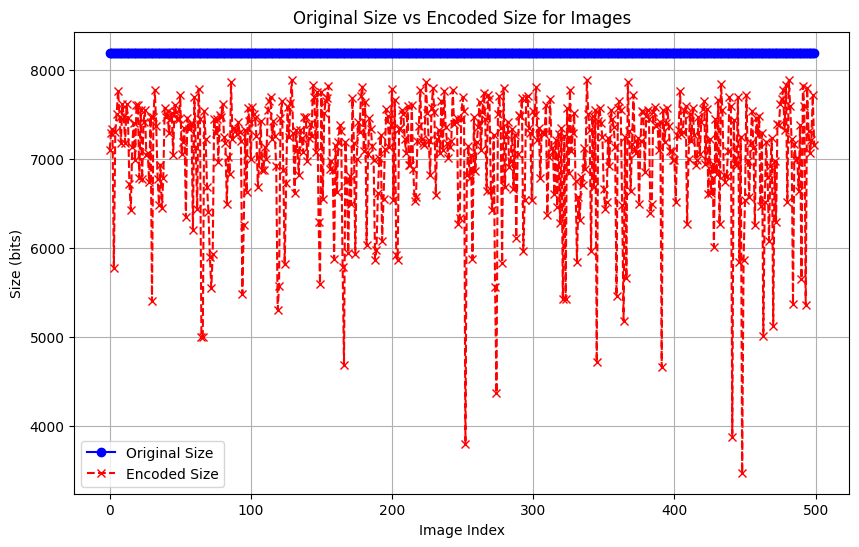

In [3]:
import numpy as np
from PIL import Image
from collections import Counter
import heapq
import os
import time
import matplotlib.pyplot as plt

# Load images into a list
def load_images(path):
    images = []
    for filename in sorted(os.listdir(path)):
        if filename.endswith(".png"):
            img_path = os.path.join(path, filename)
            img = Image.open(img_path).convert("L")  # Convert to grayscale
            img_data = np.array(img)
            images.append(img_data)
    return images

# Huffman Node class
class HuffmanNode:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

# Build Huffman Tree
def build_huffman_tree(data):
    frequency = Counter(data)
    priority_queue = [HuffmanNode(symbol, freq) for symbol, freq in frequency.items()]
    heapq.heapify(priority_queue)

    while len(priority_queue) > 1:
        left = heapq.heappop(priority_queue)
        right = heapq.heappop(priority_queue)
        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(priority_queue, merged)

    return priority_queue[0]

# Generate Huffman codes
def generate_huffman_codes(tree):
    codes = {}

    def generate_code(node, current_code):
        if node is not None:
            if node.symbol is not None:
                codes[node.symbol] = current_code
            generate_code(node.left, current_code + "0")
            generate_code(node.right, current_code + "1")

    generate_code(tree, "")
    return codes

# Encode using Huffman
def huffman_encode(image):
    flat_image = image.flatten()
    tree = build_huffman_tree(flat_image)
    codes = generate_huffman_codes(tree)
    encoded_data = ''.join(codes[pixel] for pixel in flat_image)
    return encoded_data, tree

# Decode Huffman encoded data
def huffman_decode(encoded_data, tree, shape):
    decoded_data = []
    current_node = tree
    for bit in encoded_data:
        current_node = current_node.left if bit == '0' else current_node.right
        if current_node.symbol is not None:
            decoded_data.append(current_node.symbol)
            current_node = tree

    decoded_array = np.array(decoded_data).reshape(shape)
    return decoded_array

# Load the dataset
dataset_path = '/mnt/data/Kamaljp_cifar_500_extracted'
images = load_images(dataset_path)
print(f"Loaded {len(images)} images.")

# Initialize size trackers
total_original_size = 0
total_encoded_size = 0
encoding_times = []
decoding_times = []

# Prepare lists for graph
original_sizes = []
encoded_sizes = []

# Process each image
for i, image in enumerate(images):
    print(f"Processing image {i + 1}/{len(images)}...")

    # Measure encoding time
    start_time = time.time()
    encoded_data, huffman_tree = huffman_encode(image)
    encoding_time = time.time() - start_time
    encoding_times.append(encoding_time)

    # Measure decoding time
    start_time = time.time()
    decoded_image = huffman_decode(encoded_data, huffman_tree, image.shape)
    decoding_time = time.time() - start_time
    decoding_times.append(decoding_time)

    # Verify the decoding matches the original image
    assert np.array_equal(image, decoded_image), f"Image {i + 1} decoding mismatch!"

    # Track the sizes
    original_size = image.size * 8  # Original size in bits (8 bits per pixel)
    encoded_size = len(encoded_data)  # Encoded size in bits
    total_original_size += original_size
    total_encoded_size += encoded_size

    # Track data for graph
    original_sizes.append(original_size)
    encoded_sizes.append(encoded_size)

# Calculate compression ratio
compression_ratio = total_original_size / total_encoded_size

# Display results
print(f"\nTotal Original Size: {total_original_size} bits")
print(f"Total Encoded Size: {total_encoded_size} bits")
print(f"Compression Ratio: {compression_ratio:.2f}")

# Print encoding/decoding times
for i in range(len(encoding_times)):
    print(f"Image {i + 1}: Encoding Time = {encoding_times[i]:.4f} sec, Decoding Time = {decoding_times[i]:.4f} sec")

# Plot comparison of original size vs. encoded size
plt.figure(figsize=(10, 6))
plt.plot(range(len(images)), original_sizes, label="Original Size", marker='o', linestyle='-', color='b')
plt.plot(range(len(images)), encoded_sizes, label="Encoded Size", marker='x', linestyle='--', color='r')
plt.xlabel("Image Index")
plt.ylabel("Size (bits)")
plt.title("Original Size vs Encoded Size for Images")
plt.legend()
plt.grid(True)
plt.show()
